In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 9
commitnumber = d62b618
conc = None
dv = 0.001
klin = 2e-20
molecule = o3
ng_adju = [0, 0]
ng_refs = [2, 5]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (50, 250)]
tsfc = 257
vmax = 3000
vmin = 1900
w_diffuse = [(1.55, 1.55), (1.55, 1.55, 1.55, 1.55, 1.8)]
wgt = [(0.3, 0.4), (0.5, 0.6, 0.7, 0.85, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

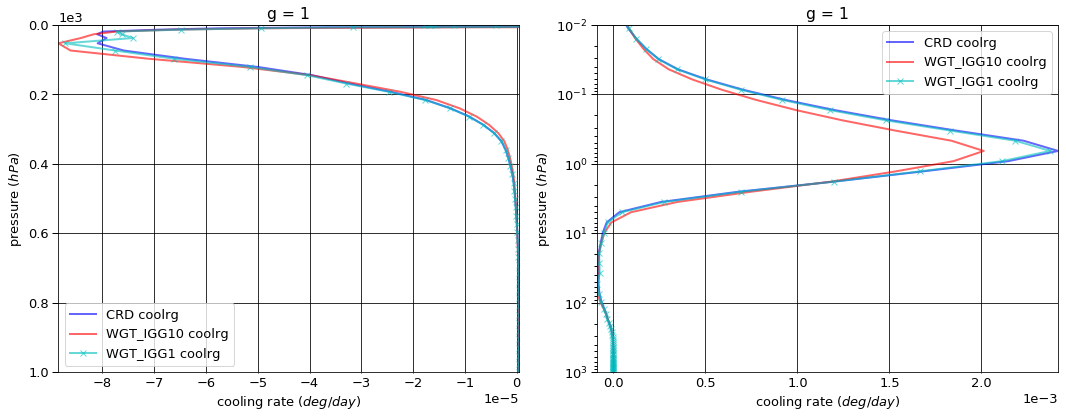

# Figure: cooling rate g-group 2

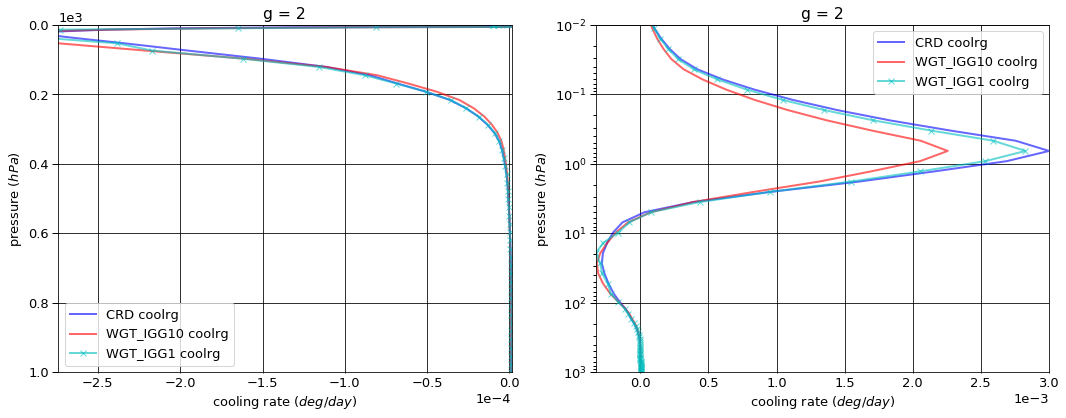

# Figure: cooling rate g-group 3

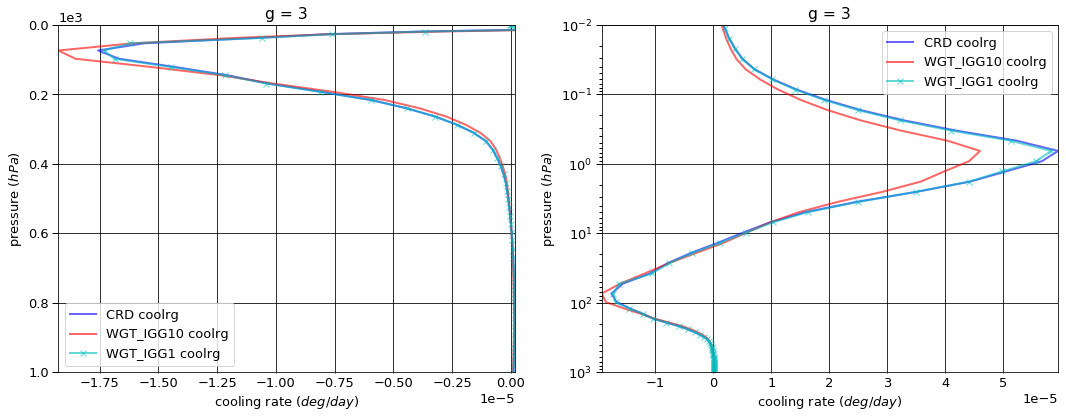

# Figure: cooling rate g-group 4

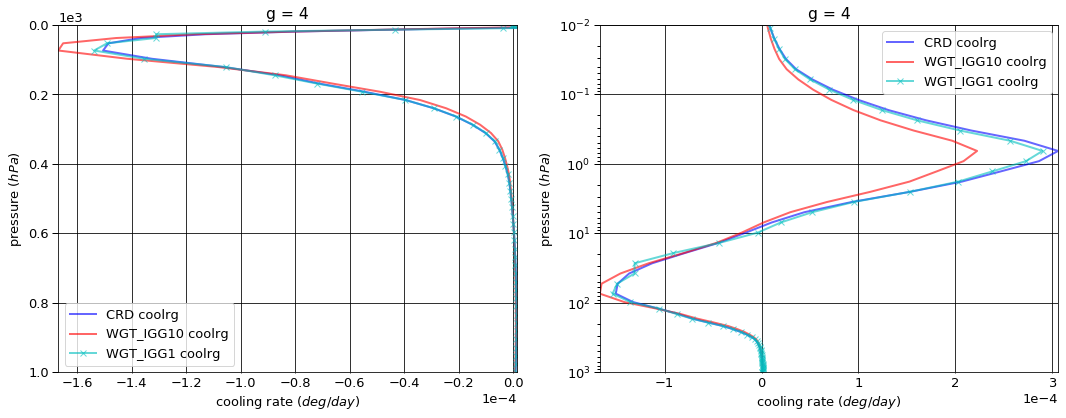

# Figure: cooling rate g-group 5

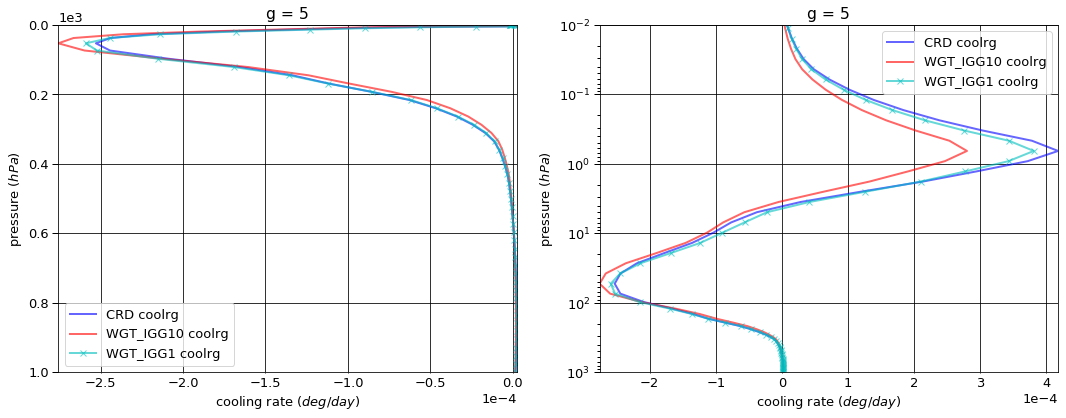

# Figure: cooling rate g-group 6

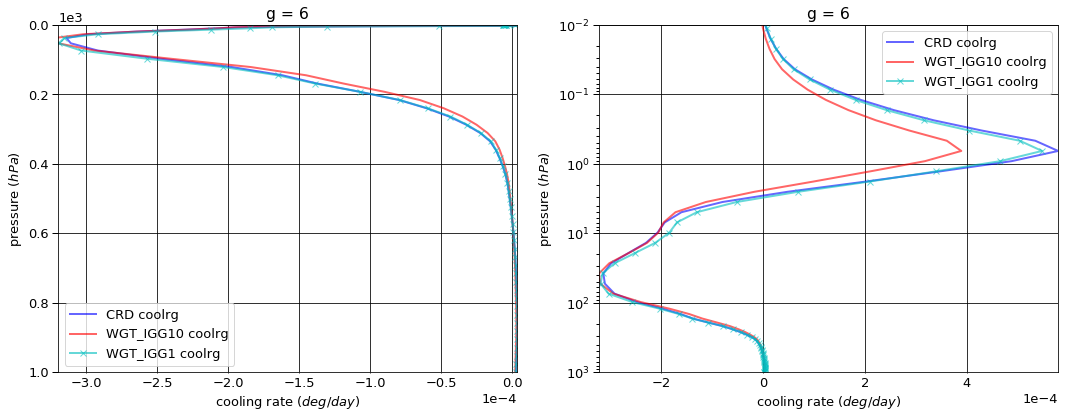

# Figure: cooling rate g-group 7

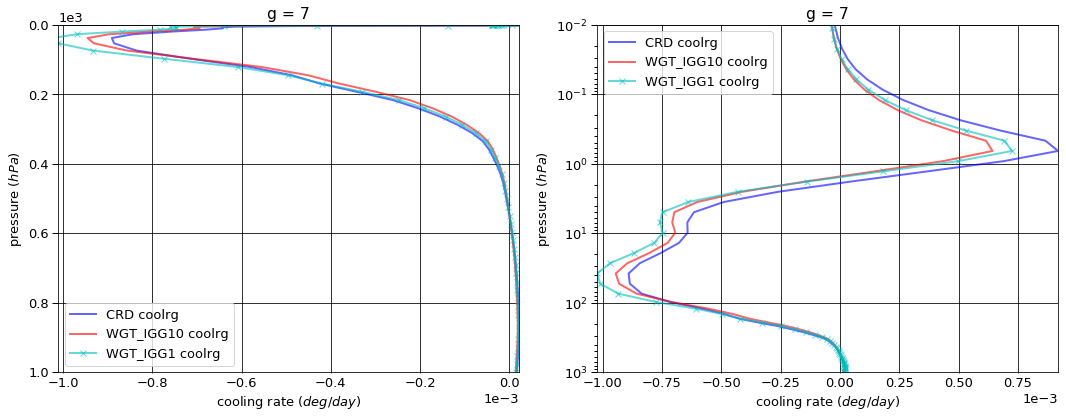

# Figure: cooling rate g-group total

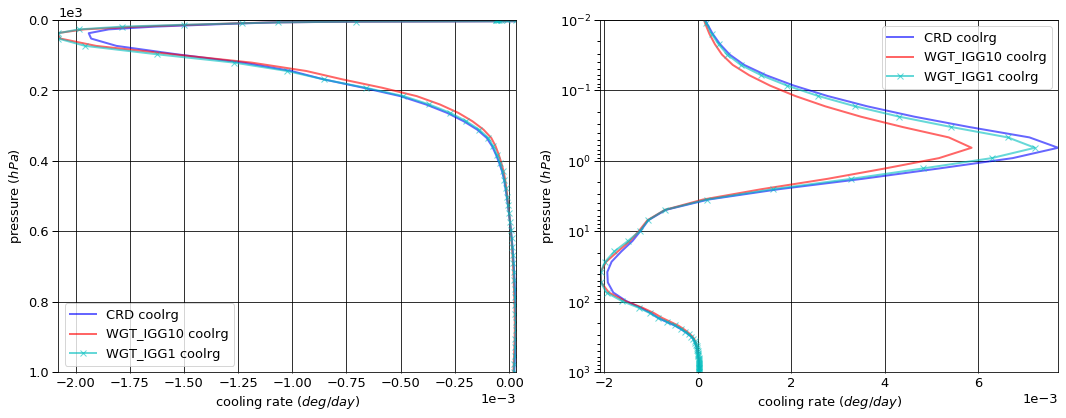

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000474  0.000000 -0.000474
  1013.0   76    -0.001623  0.000205 -0.001418
2 0.0      1     -0.001691  0.000000 -0.001691
  1013.0   76    -0.005431  0.000597 -0.004834
3 0.0      1     -0.000072  0.000000 -0.000072
  1013.0   76    -0.000437  0.000056 -0.000381
4 0.0      1     -0.001105  0.000000 -0.001105
  1013.0   76    -0.004231  0.000458 -0.003773
5 0.0      1     -0.004200  0.000000 -0.004200
  1013.0   76    -0.009545  0.000802 -0.008743
6 0.0      1     -0.011012  0.000000 -0.011012
  1013.0   76    -0.017861  0.001092 -0.016769
7 0.0      1     -1.406659  0.000000 -1.406659
  1013.0   76    -1.427780  0.003963 -1.423817


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000430  0.000000 -0.000430
  1013.0   76    -0.001626  0.000199 -0.001427
2 0.0      1     -0.001399  0.000000 -0.001399
  1013.0   76    -0.005445  0.000600 -0.004845
3 0.0      1     -0.000065  0.000000 -0.000065
  1013.0   76    -0.000438  0.000055 -0.000383
4 0.0      1     -0.001055  0.000000 -0.001055
  1013.0   76    -0.004240  0.000448 -0.003792
5 0.0      1     -0.004269  0.000000 -0.004269
  1013.0   76    -0.009568  0.000761 -0.008807
6 0.0      1     -0.011425  0.000000 -0.011425
  1013.0   76    -0.017911  0.000994 -0.016917
7 0.0      1     -1.407164  0.000000 -1.407164
  1013.0   76    -1.427682  0.003668 -1.424014


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000464  0.000000 -0.000464
  1013.0   76    -0.001626  0.000206 -0.001420
2 0.0      1     -0.001495  0.000000 -0.001495
  1013.0   76    -0.005445  0.000609 -0.004836
3 0.0      1     -0.000071  0.000000 -0.000071
  1013.0   76    -0.000438  0.000056 -0.000382
4 0.0      1     -0.001071  0.000000 -0.001071
  1013.0   76    -0.004240  0.000462 -0.003777
5 0.0      1     -0.004195  0.000000 -0.004195
  1013.0   76    -0.009568  0.000802 -0.008766
6 0.0      1     -0.011015  0.000000 -0.011015
  1013.0   76    -0.017911  0.001091 -0.016820
7 0.0      1     -1.405272  0.000000 -1.405272
  1013.0   76    -1.427682  0.004016 -1.423666


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.363329e-05  0.000000  0.000044
  1013.0   76    -3.179500e-06 -0.000006 -0.000009
2 0.0      1      2.928032e-04  0.000000  0.000293
  1013.0   76    -1.350840e-05  0.000003 -0.000010
3 0.0      1      7.059616e-06  0.000000  0.000007
  1013.0   76    -6.390800e-07 -0.000001 -0.000002
4 0.0      1      5.008590e-05  0.000000  0.000050
  1013.0   76    -8.406100e-06 -0.000011 -0.000019
5 0.0      1     -6.842340e-05  0.000000 -0.000068
  1013.0   76    -2.262210e-05 -0.000041 -0.000063
6 0.0      1     -4.126450e-04  0.000000 -0.000413
  1013.0   76    -4.939600e-05 -0.000098 -0.000148
7 0.0      1     -5.050000e-04  0.000000 -0.000505
  1013.0   76     9.780000e-05 -0.000295 -0.000197


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1      1.009984e-05  0.000000e+00  1.009984e-05
  1013.0   76    -3.179500e-06  1.434890e-06 -1.744700e-06
2 0.0      1      1.967865e-04  0.000000e+00  1.967865e-04
  1013.0   76    -1.350840e-05  1.159891e-05 -1.909500e-06
3 0.0      1      4.808420e-07  0.000000e+00  4.808420e-07
  1013.0   76    -6.390800e-07  4.616570e-07 -1.774300e-07
4 0.0      1      3.374610e-05  0.000000e+00  3.374610e-05
  1013.0   76    -8.406100e-06  4.334670e-06 -4.071400e-06
5 0.0      1      5.335000e-06  0.000000e+00  5.335000e-06
  1013.0   76    -2.262210e-05 -2.126600e-07 -2.283480e-05
6 0.0      1     -3.364000e-06  0.000000e+00 -3.364000e-06
  1013.0   76    -4.939600e-05 -1.573300e-06 -5.096900e-05
7 0.0      1      1.387000e-03  0.000000e+00  1.387000e-03
  1013.0   76     9.780000e-05  5.288400e-05  1.506000e-04

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.863460e-05
  1001.112500 75     3.468761e-07
2 0.000312    1     -1.326399e-05
  1001.112500 75     8.709210e-07
3 0.000312    1     -2.701320e-08
  1001.112500 75     1.168592e-07
4 0.000312    1     -4.639315e-07
  1001.112500 75     8.760785e-07
5 0.000312    1     -1.901227e-06
  1001.112500 75     1.679936e-06
6 0.000312    1     -4.918774e-06
  1001.112500 75     2.733590e-06
7 0.000312    1     -1.461874e-05
  1001.112500 75     1.703288e-05


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -6.709831e-06
  1001.112500 75     2.802080e-07
2 0.000312    1     -5.545358e-06
  1001.112500 75     6.917061e-07
3 0.000312    1      5.343597e-09
  1001.112500 75     9.473222e-08
4 0.000312    1     -3.237017e-07
  1001.112500 75     7.016705e-07
5 0.000312    1     -1.625695e-06
  1001.112500 75     1.345846e-06
6 0.000312    1     -4.582953e-06
  1001.112500 75     2.189702e-06
7 0.000312    1     -1.547332e-05
  1001.112500 75     1.450490e-05


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.575803e-05
  1001.112500 75     3.477657e-07
2 0.000312    1     -9.665260e-06
  1001.112500 75     8.660434e-07
3 0.000312    1     -1.198661e-08
  1001.112500 75     1.167317e-07
4 0.000312    1     -2.846409e-07
  1001.112500 75     8.661540e-07
5 0.000312    1     -1.417280e-06
  1001.112500 75     1.667798e-06
6 0.000312    1     -4.290755e-06
  1001.112500 75     2.690004e-06
7 0.000312    1     -1.666886e-05
  1001.112500 75     1.597742e-05


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.192477e-05
  1001.112500 75    -6.666813e-08
2 0.000312    1      7.718629e-06
  1001.112500 75    -1.792150e-07
3 0.000312    1      3.235679e-08
  1001.112500 75    -2.212696e-08
4 0.000312    1      1.402298e-07
  1001.112500 75    -1.744080e-07
5 0.000312    1      2.755312e-07
  1001.112500 75    -3.340900e-07
6 0.000312    1      3.358203e-07
  1001.112500 75    -5.438872e-07
7 0.000312    1     -8.545750e-07
  1001.112500 75    -2.527975e-06


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.876571e-06
  1001.112500 75     8.895800e-10
2 0.000312    1      3.598727e-06
  1001.112500 75    -4.877610e-09
3 0.000312    1      1.502658e-08
  1001.112500 75    -1.274700e-10
4 0.000312    1      1.792906e-07
  1001.112500 75    -9.924480e-09
5 0.000312    1      4.839465e-07
  1001.112500 75    -1.213780e-08
6 0.000312    1      6.280185e-07
  1001.112500 75    -4.358580e-08
7 0.000312    1     -2.050119e-06
  1001.112500 75    -1.055455e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.425213,0.000000,-1.425213
1013.0,76,-1.466909,0.007173,-1.459736



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.425806,0.000000,-1.425806
1013.0,76,-1.466909,0.006724,-1.460184



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.423583,0.000000,-1.423583
1013.0,76,-1.466909,0.007242,-1.459667



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.924864e-04,0.000000,-0.000592
1013.0,76,4.882000e-08,-0.000448,-0.000448



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.630084e-03,0.000000,0.001630
1013.0,76,4.882000e-08,0.000069,0.000069


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000054
1001.112500,75,0.000024



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000034
1001.112500,75,0.000020



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000048
1001.112500,75,0.000023



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000020
1001.112500,75,-0.000004



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000006
1001.112500,75,-0.000001


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000563,0.001108
2,0.001859,0.003712
3,0.000154,0.000299
4,0.001466,0.002890
5,0.003276,0.006522
6,0.006071,0.012210
7,0.986611,0.973259


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.918561e-19
2,1.194154e-19
3,1.686077e-19
4,8.284609e-20
5,4.070676e-20
6,2.000143e-20
7,1.234195e-27


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.918561e-19,NaN,0.000563,0.001108,0.000563,0.001108,1.0
2,1.194154e-19,2.427852e-01,0.001859,0.003712,0.002422,0.004820,1.0
3,1.686077e-19,1.411943e+00,0.000154,0.000299,0.002575,0.005119,50.0
4,8.284609e-20,4.913540e-01,0.001466,0.002890,0.004042,0.008009,50.0
5,4.070676e-20,4.913540e-01,0.003276,0.006522,0.007318,0.014531,50.0
6,2.000143e-20,4.913540e-01,0.006071,0.012210,0.013389,0.026741,50.0
7,1.234195e-27,6.170535e-08,0.986611,0.973259,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
